In [1]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import confusion_matrix, classification_report
import warnings

warnings.filterwarnings("ignore")

# Style
plt.style.use("seaborn-v0_8-darkgrid")
sns.set_palette("husl")

# Output directory
output_dir = Path("../results/final_comparison")
output_dir.mkdir(parents=True, exist_ok=True)

print("✅ Imports successful!")
print(f"📁 Output directory: {output_dir}")


✅ Imports successful!
📁 Output directory: ..\results\final_comparison


In [4]:
def load_model_results(results_dir="../results"):
    results_dir = Path(results_dir)
    all_results = {}

    baseline_models = ["fasttext", "bilstm", "transformer"]
    pretrained_models = ["roberta", "bertweet"]
    ensemble_models = ["voting", "stacking", "weighted"]

    # Baseline
    for model in baseline_models:
        result_file = results_dir / "baseline" / model / "results.pkl"
        if result_file.exists():
            with open(result_file, "rb") as f:
                all_results[model] = pickle.load(f)
                print(f"✅ Loaded {model}")
        else:
            print(f"⚠️  {model} not found")

    # Pretrained
    for model in pretrained_models:
        result_file = results_dir / "pretrained" / model / "results.pkl"
        if result_file.exists():
            with open(result_file, "rb") as f:
                all_results[model] = pickle.load(f)
                print(f"✅ Loaded {model}")
        else:
            print(f"⚠️  {model} not found")

    # Ensembles
    for model in ensemble_models:
        for subdir in results_dir.glob("ensemble/*"):
            if model in subdir.name.lower():
                result_file = subdir / "results.pkl"
                if result_file.exists():
                    with open(result_file, "rb") as f:
                        all_results[f"ensemble_{model}"] = pickle.load(f)
                        print(f"✅ Loaded ensemble_{model}")
                break

    return all_results


In [ ]:
all_results = load_model_results()

print(f"\n📊 Total models loaded: {len(all_results)}")
print("Models:", list(all_results.keys()))


✅ Loaded fasttext
✅ Loaded bilstm
✅ Loaded transformer
✅ Loaded roberta
✅ Loaded bertweet
✅ Loaded ensemble_voting
✅ Loaded ensemble_stacking
✅ Loaded ensemble_weighted

📊 Total models loaded: 8
Models: ['fasttext', 'bilstm', 'transformer', 'roberta', 'bertweet', 'ensemble_voting', 'ensemble_stacking', 'ensemble_weighted']


In [14]:
def create_baseline_comparison_table(all_results):
    baseline_models = ["fasttext", "bilstm", "transformer"]
    rows = []

    for model in baseline_models:
        if model not in all_results:
            continue

        r = all_results[model]
        m = r["metrics"]   # 👈 THIS WAS THE MISSING PIECE

        rows.append({
            "Model": model.upper(),
            "Accuracy": m["accuracy"],
            "Precision": m["precision_macro"],
            "Recall": m["recall_macro"],
            "F1-Score": m["f1_macro"],
            "F1 (Weighted)": m["f1_weighted"]
        })

    df = pd.DataFrame(rows).sort_values("F1-Score", ascending=False)
    return df


In [15]:
baseline_df = create_baseline_comparison_table(all_results)

print("=" * 80)
print("BASELINE MODELS COMPARISON")
print("=" * 80)
print(baseline_df.to_string(index=False))
print("=" * 80)

for col in ["Accuracy", "Precision", "Recall", "F1-Score"]:
    best = baseline_df.loc[baseline_df[col].idxmax()]
    print(f"🏆 Best {col}: {best['Model']} ({best[col]:.4f})")


BASELINE MODELS COMPARISON
      Model  Accuracy  Precision   Recall  F1-Score  F1 (Weighted)
TRANSFORMER  0.689821   0.690875 0.692999  0.691865       0.689247
   FASTTEXT  0.652369   0.657459 0.656297  0.656380       0.653240
     BILSTM  0.647247   0.644169 0.652982  0.645885       0.642455
🏆 Best Accuracy: TRANSFORMER (0.6898)
🏆 Best Precision: TRANSFORMER (0.6909)
🏆 Best Recall: TRANSFORMER (0.6930)
🏆 Best F1-Score: TRANSFORMER (0.6919)


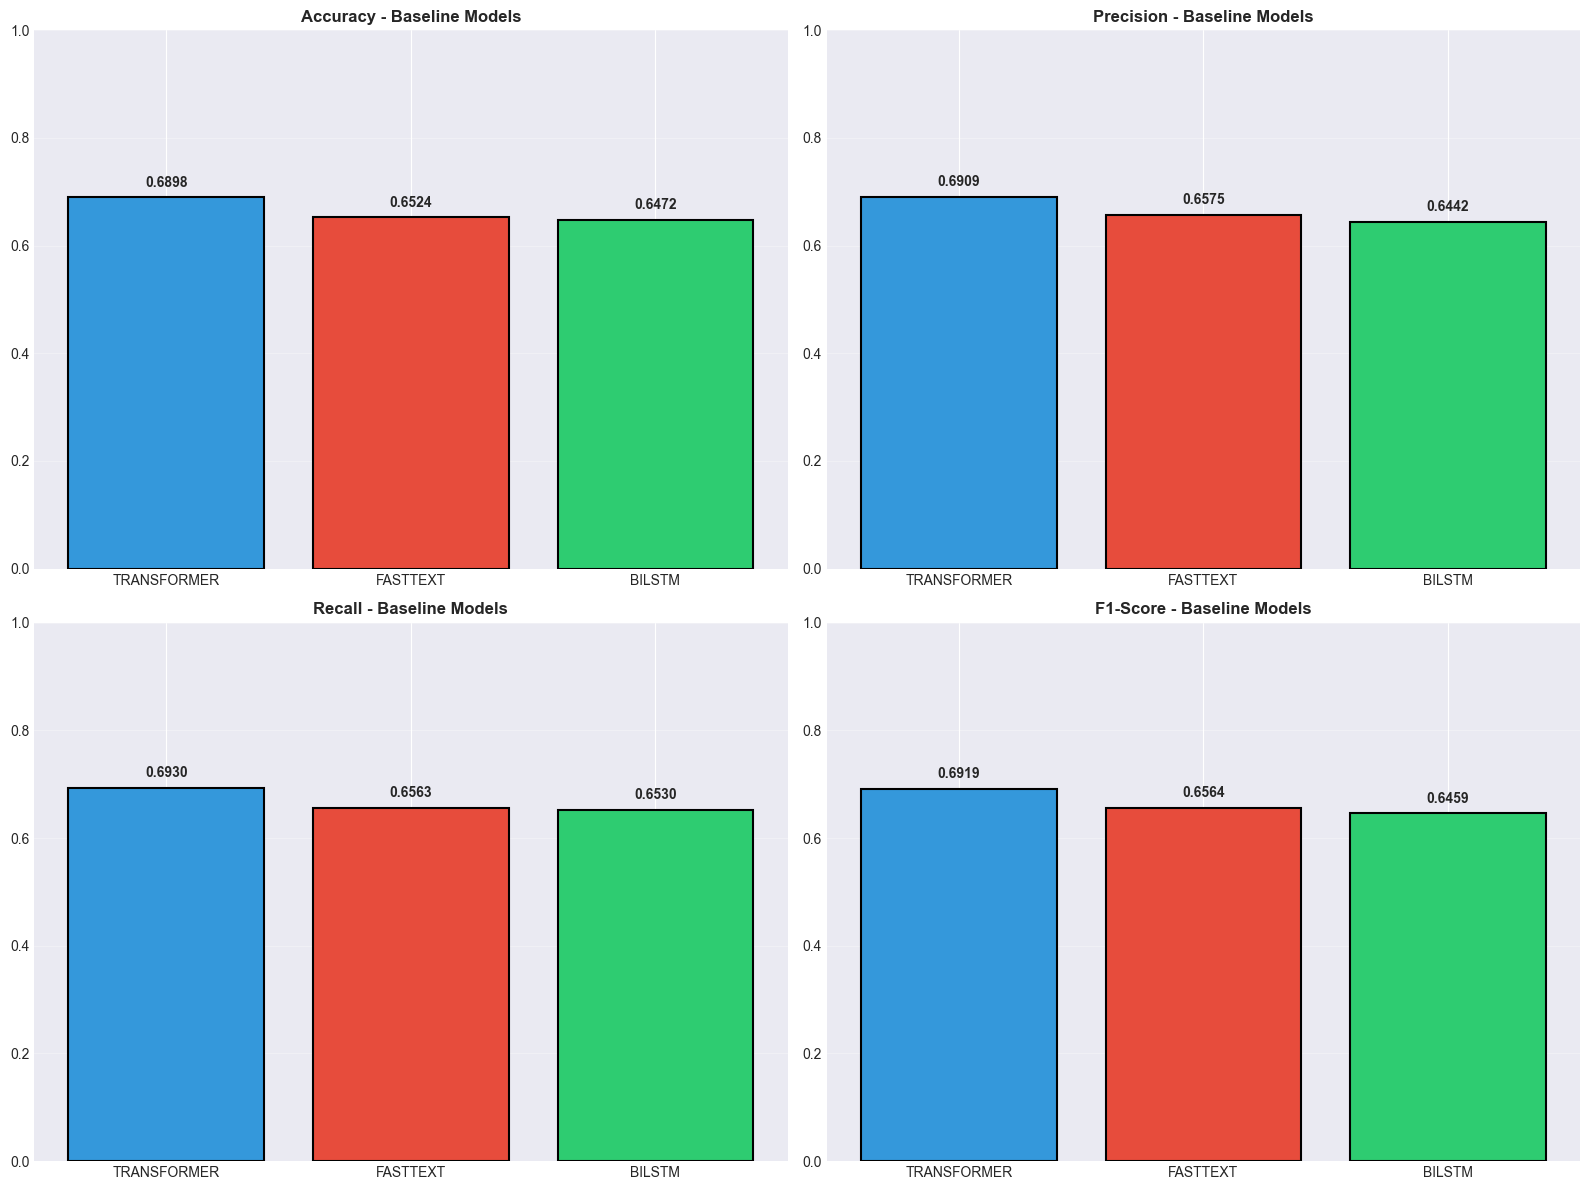

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
colors = ["#3498db", "#e74c3c", "#2ecc71"]

for i, metric in enumerate(metrics):
    ax = axes[i // 2, i % 2]
    bars = ax.bar(baseline_df["Model"], baseline_df[metric],
                  color=colors, edgecolor="black", linewidth=1.5)

    ax.set_title(f"{metric} - Baseline Models", fontweight="bold")
    ax.set_ylim(0, 1)
    ax.grid(axis="y", alpha=0.3)

    for bar in bars:
        ax.text(bar.get_x() + bar.get_width()/2,
                bar.get_height() + 0.02,
                f"{bar.get_height():.4f}",
                ha="center", fontweight="bold")

plt.tight_layout()
plt.savefig(output_dir / "baseline_comparison_bars.png", dpi=300)
plt.show()


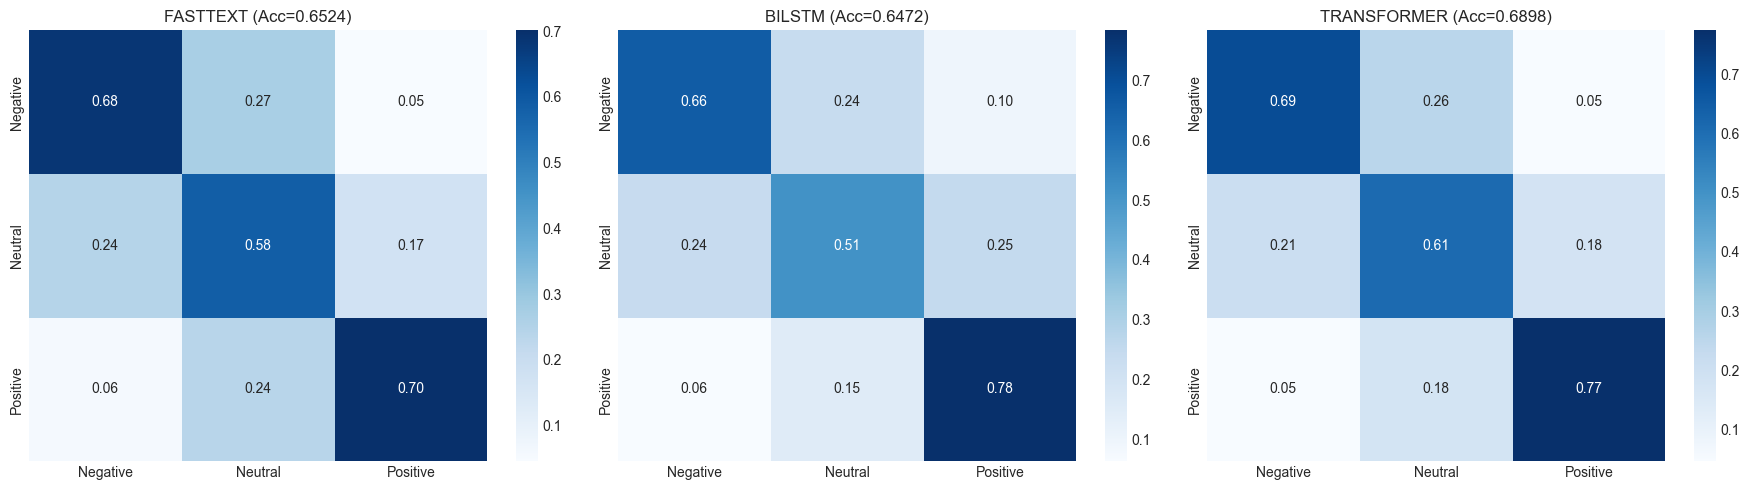

In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

class_names = ["Negative", "Neutral", "Positive"]
baseline_models = ["fasttext", "bilstm", "transformer"]

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i, model in enumerate(baseline_models):
    if model not in all_results:
        continue

    r = all_results[model]

    # Compute confusion matrix
    cm = confusion_matrix(r["labels"], r["predictions"])
    cm = cm / cm.sum(axis=1, keepdims=True)

    sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues",
                xticklabels=class_names,
                yticklabels=class_names,
                ax=axes[i])

    # Compute accuracy
    acc = accuracy_score(r["labels"], r["predictions"])
    axes[i].set_title(f"{model.upper()} (Acc={acc:.4f})")

plt.tight_layout()
plt.savefig(output_dir / "baseline_confusion_matrices.png", dpi=300)
plt.show()


In [20]:
def create_ensemble_comparison_table(all_results):
    rows = []

    for k, r in all_results.items():
        if "ensemble" in k.lower():
            rows.append({
                "Model": k.replace("ensemble_", "").upper(),
                "Accuracy": r.get("accuracy", 0),
                "Precision": r.get("precision_macro", 0),
                "Recall": r.get("recall_macro", 0),
                "F1-Score": r.get("f1_macro", 0),
                "F1 (Weighted)": r.get("f1_weighted", 0)
            })

    return pd.DataFrame(rows).sort_values("F1-Score", ascending=False)


In [21]:
ensemble_df = create_ensemble_comparison_table(all_results)
print(ensemble_df.to_string(index=False))


   Model  Accuracy  Precision   Recall  F1-Score  F1 (Weighted)
WEIGHTED  0.712868   0.715964 0.715227  0.715573              0
  VOTING  0.708707   0.711886 0.711045  0.711447              0
STACKING  0.691421   0.693002 0.694046  0.693472              0


In [22]:
def create_complete_comparison_table(all_results):
    rows = []

    for model, r in all_results.items():
        if "ensemble" in model:
            cat = "Ensemble"
            name = model.replace("ensemble_", "").upper()
        elif model in ["roberta", "bertweet"]:
            cat = "Pretrained"
            name = model.upper()
        else:
            cat = "Baseline"
            name = model.upper()

        rows.append({
            "Category": cat,
            "Model": name,
            "Accuracy": r.get("accuracy", 0),
            "Precision": r.get("precision_macro", 0),
            "Recall": r.get("recall_macro", 0),
            "F1-Score": r.get("f1_macro", 0),
            "F1 (Weighted)": r.get("f1_weighted", 0)
        })

    return pd.DataFrame(rows)


In [23]:

complete_df = create_complete_comparison_table(all_results)

complete_df.to_csv(output_dir / "complete_comparison.csv", index=False)
baseline_df.to_csv(output_dir / "baseline_comparison.csv", index=False)
ensemble_df.to_csv(output_dir / "ensemble_comparison.csv", index=False)

print("✅ CSV files saved")


✅ CSV files saved
